# _**Klasyfikacja**_

W tym notebooku poznaczie podstawowe klasyfikatory takie jak:
- Regresja logistyczna,
- k najbliższych sąsiadów.

W pierwszej części przeuczymy model k najbliższych sąsiadów na zbiorze iris. W drugiej części zastosujemy regresję logistyczną na zbiorze Titanic.

In [1]:
import numpy as np
np.random.seed(0)


----
## 1. Klasyfikator k najbliższych sąsiadów
Skorzystamy ze słynnego zbioru iris, który zawiera 150 próbek trzech gatunków irysów: Iris setosa, Iris versicolor, Iris virginica. Każda próbka zawiera cztery cechy: długość i szerokość płatków oraz długość i szerokość działki kielicha. Naszym zadaniem będzie klasyfikacja irysów na podstawie tych cech.

In [2]:
from seaborn import load_dataset

pinguin = load_dataset('penguins')
pinguin

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


In [3]:
X = pinguin.drop(columns='species')
y = pinguin['species']
X.shape, y.shape

((344, 6), (344,))

In [4]:
type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [5]:
target_names = y.unique()
target_names

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [6]:
X.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Torgersen,36.7,19.3,193.0,3450.0,Female


In [7]:
y.head()

0    Adelie
1    Adelie
2    Adelie
3    Adelie
4    Adelie
Name: species, dtype: object

In [8]:
target_names = {v: k for k, v in enumerate(target_names)}
target_names

{'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2}

In [9]:
y = y.map(target_names)
y

0      0
1      0
2      0
3      0
4      0
      ..
339    2
340    2
341    2
342    2
343    2
Name: species, Length: 344, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((230, 6), (114, 6), (230,), (114,))

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230 entries, 15 to 102
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   island             230 non-null    object 
 1   bill_length_mm     229 non-null    float64
 2   bill_depth_mm      229 non-null    float64
 3   flipper_length_mm  229 non-null    float64
 4   body_mass_g        229 non-null    float64
 5   sex                222 non-null    object 
dtypes: float64(4), object(2)
memory usage: 12.6+ KB


In [13]:
X_train['sex'].value_counts()

sex
Female    114
Male      108
Name: count, dtype: int64

In [14]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


num_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
cat_features = ['island', 'sex']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first')) # drop='first' pomaga uniknąć problemu zmiennej bez informacji
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['bill_length_mm', 'bill_depth_mm',
                                  'flipper_length_mm', 'body_mass_g']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['island', 'sex'])])

In [15]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
preprocessor.get_feature_names_out()

array(['num__bill_length_mm', 'num__bill_depth_mm',
       'num__flipper_length_mm', 'num__body_mass_g', 'cat__island_Dream',
       'cat__island_Torgersen', 'cat__sex_Male'], dtype=object)

In [16]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_preprocessed, y_train)

KNeighborsClassifier(n_neighbors=3)

In [17]:
y_pred = knn.predict(X_test_preprocessed)

### Średnie Micro i Macro
W klasyfikacji wieloklasowej, średnie micro i macro są dwoma różnymi sposobami obliczania miar jakości klasyfikacji. Średnia micro oblicza miarę jakości klasyfikacji, traktując każdy punkt danych jako pojedynczy punkt danych, podczas gdy średnia macro oblicza miarę jakości klasyfikacji, traktując każdą klasę jako pojedynczy punkt danych. Wiecej tutaj: https://sklearn-evaluation.ploomber.io/en/latest/classification/micro_macro.html

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
print(f'Precision: {precision_score(y_test, y_pred, average="macro"):.3f}')
print(f'Recall: {recall_score(y_test, y_pred, average="macro"):.3f}')
print(f'F1 score: {f1_score(y_test, y_pred, average="macro"):.3f}')
print(f'Confusion matrix:\n{confusion_matrix(y_test, y_pred)}')


Accuracy: 0.991
Precision: 0.986
Recall: 0.994
F1 score: 0.989
Confusion matrix:
[[53  1  0]
 [ 0 22  0]
 [ 0  0 38]]


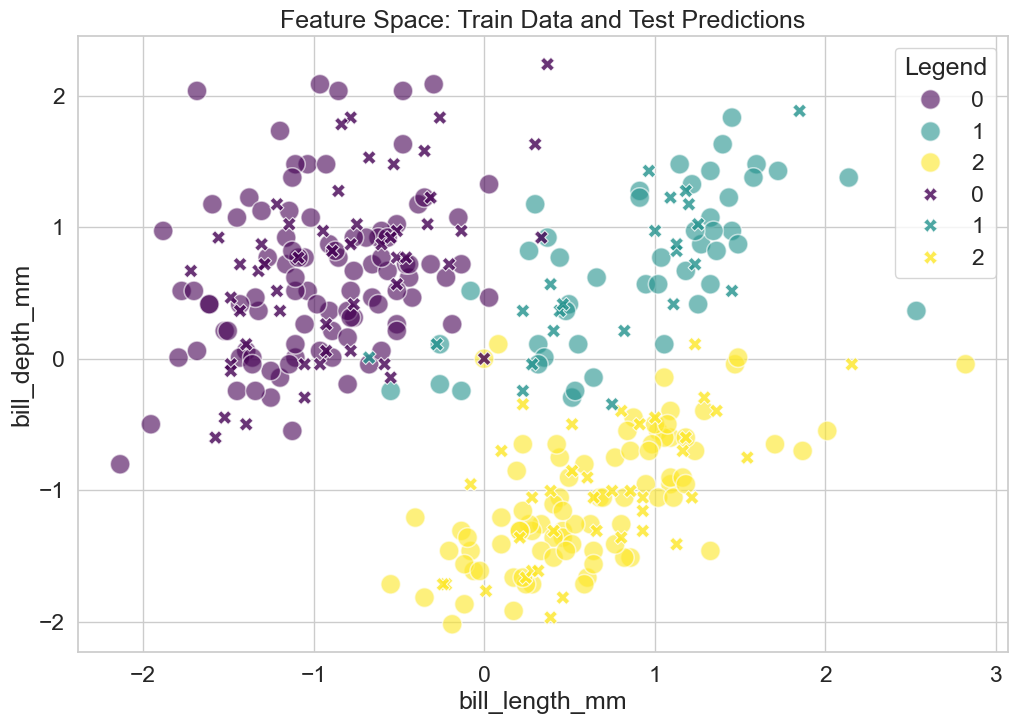

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


sns.set(style='whitegrid', font_scale=1.5)
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x=X_train_preprocessed[:, 0],
    y=X_train_preprocessed[:, 1],
    hue=y_train,
    palette='viridis',
    style=y_train,
    s=200,  
    alpha=0.6,
    markers='o'  
)

sns.scatterplot(
    x=X_test_preprocessed[:, 0],
    y=X_test_preprocessed[:, 1],
    hue=y_pred,
    palette='viridis',
    style=y_pred,
    s=100,  
    alpha=0.8,
    markers='X' 
)

# Add labels and title
plt.xlabel('bill_length_mm')
plt.ylabel('bill_depth_mm')
plt.title('Feature Space: Train Data and Test Predictions')
plt.legend(title='Legend')
plt.show()


-----
## 2. Regresja logistyczna

W tej części zastosujemy regresję logistyczną do przewidywania, które osoby przeżyły katastrofę Titanica.

Skorzystamy z danych Titanic, które zawierają informacje o pasażerach takie jak wiek, płeć, klasa biletu, itp. Naszym zadaniem będzie przewidzenie, które osoby przeżyły katastrofę na podstawie tych danych.

In [20]:
from seaborn import load_dataset


titanic = load_dataset('titanic')
titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [21]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [22]:
X = titanic.drop(columns='survived')
y = titanic['survived']

X.head()

,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [23]:
X["who"].value_counts()

who
man      537
woman    271
child     83
Name: count, dtype: int64

Widać że w dużej części kolumna "who" ma te same informacje co kolumna "sex", jedyną nową informacją jest fakt czy osoba była dzieckiem. Dlatego zmienimy ją na kolumnę binarną "is_child".

In [24]:
X["is_child"] = X["who"] == "child"
X["is_child"].value_counts()

is_child
False    808
True      83
Name: count, dtype: int64

In [25]:
X.drop(columns='who', inplace=True)

Jako, że mamy teraz informacje o płci pasarzerów i tym czy są dziećmi, kolumna "adult_male" nie ma żadnycm nowych informacji. Usuniemy ją.

In [26]:
X.drop(columns='adult_male', inplace=True)

In [27]:
X.head()

,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alive,alone,is_child
0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,no,False,False
1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,yes,False,False
2,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,yes,True,False
3,1,female,35.0,1,0,53.1000,S,First,C,Southampton,yes,False,False
4,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,no,True,False


In [28]:
X.drop(columns='alive', inplace=True) # alive za bardzo koreluje z survived przez co zachodzi label leakage

In [29]:
X["embarked"].value_counts()

embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [30]:
X["embark_town"].value_counts()

embark_town
Southampton    644
Cherbourg      168
Queenstown      77
Name: count, dtype: int64

In [31]:
cities_dict = {'Southampton': 'S', 'Cherbourg': 'C', 'Queenstown': 'Q'}
(X["embarked"] == X["embark_town"].map(cities_dict)).sum()/len(X)

0.9977553310886644

In [32]:
X.drop(columns='embarked', inplace=True)

In [33]:
X.head()

,pclass,sex,age,sibsp,parch,fare,class,deck,embark_town,alone,is_child
0,3,male,22.0,1,0,7.2500,Third,NaN,Southampton,False,False
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,False,False
2,3,female,26.0,0,0,7.9250,Third,NaN,Southampton,True,False
3,1,female,35.0,1,0,53.1000,First,C,Southampton,False,False
4,3,male,35.0,0,0,8.0500,Third,NaN,Southampton,True,False


In [34]:
X["class"].value_counts()

class
Third     491
First     216
Second    184
Name: count, dtype: int64

In [35]:
X["pclass"].value_counts()

pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [36]:
(X["pclass"] == X["class"].map({'First': 1, 'Second': 2, 'Third': 3})).sum()/len(X)

1.0

In [37]:
X.drop(columns='pclass', inplace=True)

In [38]:
X["deck"].value_counts()

deck
C    59
B    47
D    33
E    32
A    15
F    13
G     4
Name: count, dtype: int64

In [45]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


num_features = ['age', 'fare']
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

onehot_features = ['sex', 'embark_town', 'deck', 'alone', 'is_child']
onehot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'))
])

ord_features = ['class']
ord_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[['First', 'Second', 'Third']]))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('onehot', onehot_pipeline, onehot_features),
    ('ord', ord_pipeline, ord_features)
])
preprocessor    

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'fare']),
                                ('onehot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist'))]),
                                 ['sex', 'embark_town', 'deck', 'alone',
                                  'is_child']),
                                ('ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder(categories=[['First',
                                                                              'Second',
                                                                              'Third']]))]),
                                 ['class'])])

In [47]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [48]:
preprocessor.get_feature_names_out()

array(['num__age', 'num__fare', 'onehot__sex_male',
       'onehot__embark_town_Queenstown',
       'onehot__embark_town_Southampton', 'onehot__embark_town_missing',
       'onehot__deck_B', 'onehot__deck_C', 'onehot__deck_D',
       'onehot__deck_E', 'onehot__deck_F', 'onehot__deck_G',
       'onehot__deck_missing', 'onehot__alone_True',
       'onehot__is_child_True', 'ord__class'], dtype=object)

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score


logreg = LogisticRegression()
logreg.fit(X_train_preprocessed, y_train)

y_pred = logreg.predict(X_test_preprocessed)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
print(f'Precision: {precision_score(y_test, y_pred):.3f}')
print(f'Recall: {recall_score(y_test, y_pred):.3f}')
print(f'F1 score: {f1_score(y_test, y_pred):.3f}')
print(f'Confusion matrix:\n{confusion_matrix(y_test, y_pred)}')

Accuracy: 0.799
Precision: 0.757
Recall: 0.757
F1 score: 0.757
Confusion matrix:
[[87 18]
 [18 56]]


Jakimś cudem stworzyliśmy perfekcyjny klasyfikator.

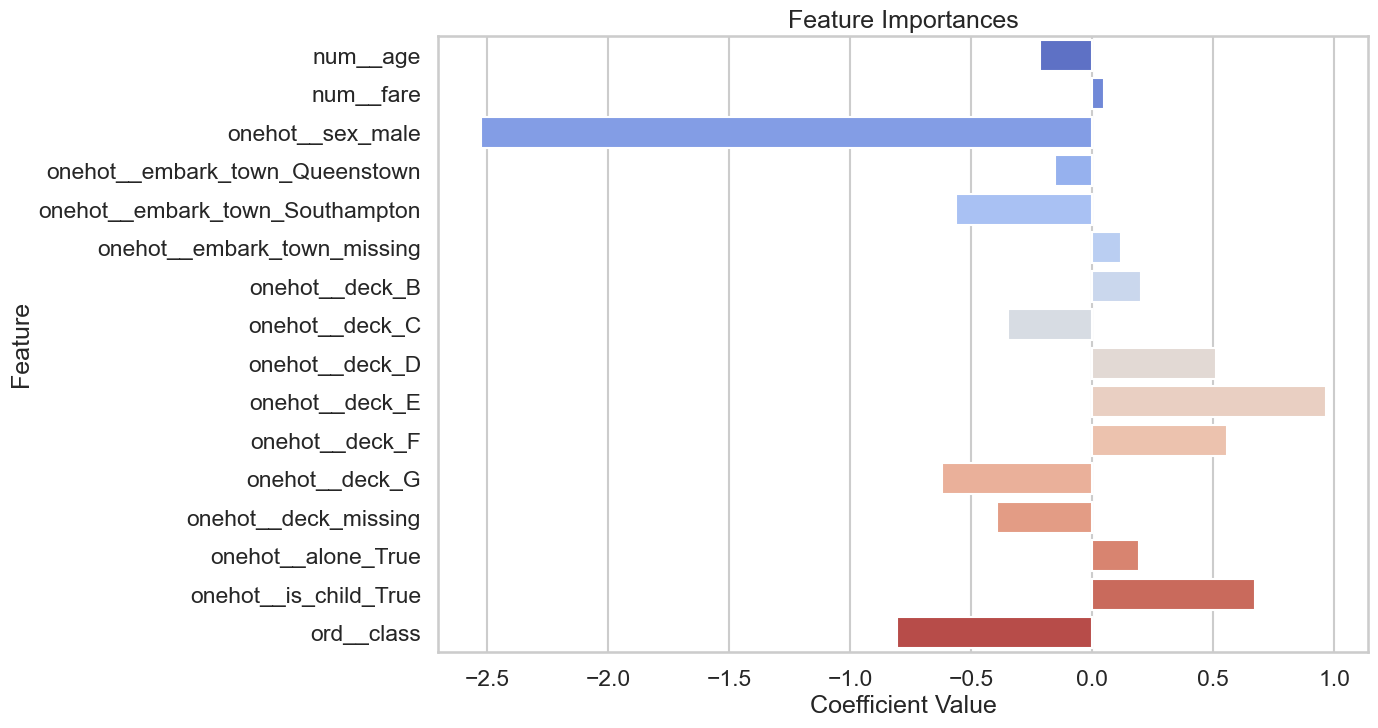

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

importance_df = pd.DataFrame({
    'Feature': preprocessor.get_feature_names_out(),
    'Importance': logreg.coef_[0]
})
# Set the style and context for the plot
sns.set(style='whitegrid', context='talk')

# Create the barplot
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_df,
    palette='coolwarm',
    orient='h'
)

# Add labels and title
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


In [ ]:
coef = logreg.coef_[0]
bias = logreg.intercept_[0]

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [53]:
example_person = X_test.iloc[0]
example_person

sex                 male
age                  NaN
sibsp                  1
parch                  1
fare             15.2458
class              Third
deck                 NaN
embark_town    Cherbourg
alone              False
is_child           False
Name: 709, dtype: object

In [58]:
example_person_preprocessed = preprocessor.transform(pd.DataFrame([example_person]))
example_person_preprocessed = pd.Series(example_person_preprocessed.flatten(), index=preprocessor.get_feature_names_out().tolist())
example_person_preprocessed

num__age                          -0.092634
num__fare                         -0.333901
onehot__sex_male                   1.000000
onehot__embark_town_Queenstown     0.000000
onehot__embark_town_Southampton    0.000000
onehot__embark_town_missing        0.000000
onehot__deck_B                     0.000000
onehot__deck_C                     0.000000
onehot__deck_D                     0.000000
onehot__deck_E                     0.000000
onehot__deck_F                     0.000000
onehot__deck_G                     0.000000
onehot__deck_missing               1.000000
onehot__alone_True                 0.000000
onehot__is_child_True              0.000000
ord__class                         2.000000
dtype: float64

In [60]:
analitic_pred = sigmoid(np.dot(coef, example_person_preprocessed) + bias)
analitic_pred, analitic_pred>0.5

(0.12404295062850383, False)

In [68]:
example_person_np = example_person_preprocessed.values.reshape(1, -1)
logreg.predict(example_person_np)

array([0], dtype=int64)